In [2]:
import os
import shutil

# Move kaggle.json to the correct directory
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Set permissions (just to be safe)
os.chmod('/root/.kaggle/kaggle.json', 0o600)
#!/bin/bash
#!/bin/bash
!kaggle datasets download msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 96% 58.0M/60.3M [00:00<00:00, 135MB/s]
100% 60.3M/60.3M [00:00<00:00, 124MB/s]


In [3]:
import zipfile

with zipfile.ZipFile('/content/fer2013.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/fer2013')

print('Dataset extracted successfully!')

Dataset extracted successfully!


In [4]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Flatten, Conv2D, BatchNormalization, Activation
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.utils import plot_model
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import shap

warnings.filterwarnings('ignore')

In [5]:
# Load the dataset paths
train_dir = '/content/fer2013/train'
val_dir = '/content/fer2013/test'

# Define the image size
img_size = 48

# Define the emotion labels
emotion_list = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


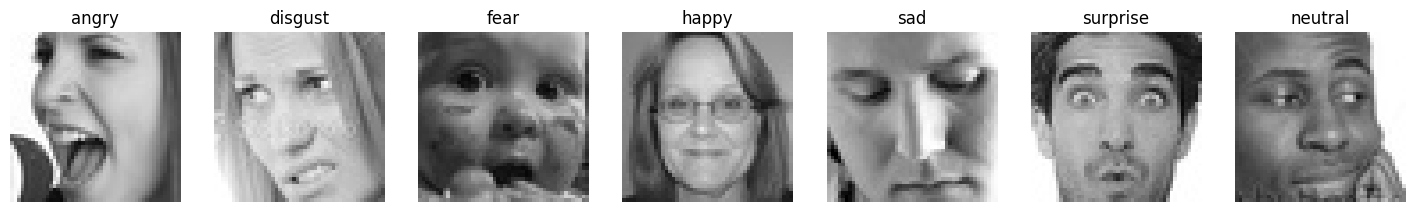

In [6]:
# Plot sample images
plt.figure(figsize=(18, 22))
i = 1
for expression in emotion_list:
    img = load_img((train_dir + '/' + expression + '/' + os.listdir(train_dir + '/' + expression)[59]))
    plt.subplot(1, 7, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [7]:

# Data generators for train and validation
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

batch_size = 64

train_set = datagen_train.flow_from_directory(
    directory=train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode="categorical",
    shuffle=True
)

val_set = datagen_val.flow_from_directory(
    directory=val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode="categorical",
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
# Build the CNN model
model = tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Train the model
history = model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    validation_data=val_set,
    validation_steps=val_set.n // val_set.batch_size,
    epochs=50
)

Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.2103 - loss: 2.2699 - val_accuracy: 0.2914 - val_loss: 2.0184
Epoch 2/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3281 - loss: 1.6784 - val_accuracy: 0.0000e+00 - val_loss: 4.4785
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.3669 - loss: 1.6518 - val_accuracy: 0.3934 - val_loss: 1.5374
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accuracy: 0.4219 - loss: 1.4463 - val_accuracy: 0.3000 - val_loss: 2.0401
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.4818 - loss: 1.3526 - val_accuracy: 0.4830 - val_loss: 1.3273
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 54us/step - accuracy: 0.4844 - loss: 1.3668 - val_accuracy: 0.7000 - val_loss: 0.8097
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.5404 - loss: 1.2130 - val_accuracy: 0.5121 - val_loss: 1.2800
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - accuracy: 0.5938 - loss: 1.1552 - 

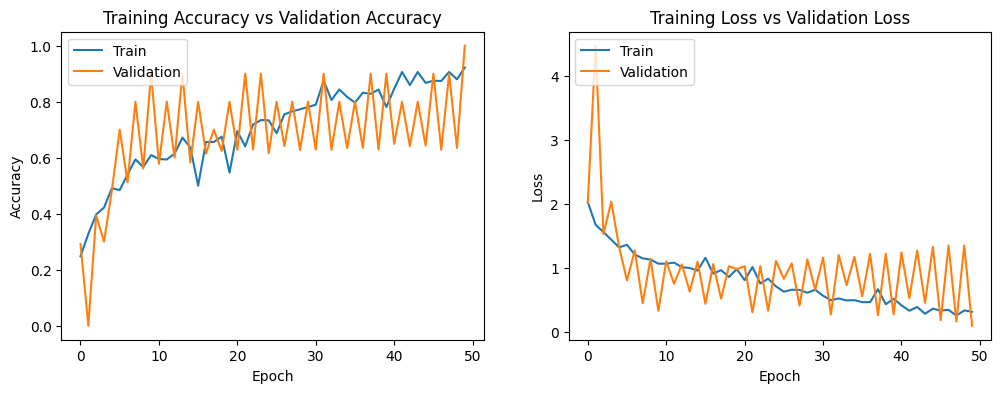

In [11]:

# Model performance plots
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12, 4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [12]:
# Evaluate the model on validation set
val_preds = model.predict(val_set)
val_preds_class = np.argmax(val_preds, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


In [13]:
# Compute precision, recall, f1 score
precision = precision_score(val_set.classes, val_preds_class, average='weighted')
recall = recall_score(val_set.classes, val_preds_class, average='weighted')
f1 = f1_score(val_set.classes, val_preds_class, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.6269056108069831
Recall: 0.6347171914182224
F1 Score: 0.6291543563814694


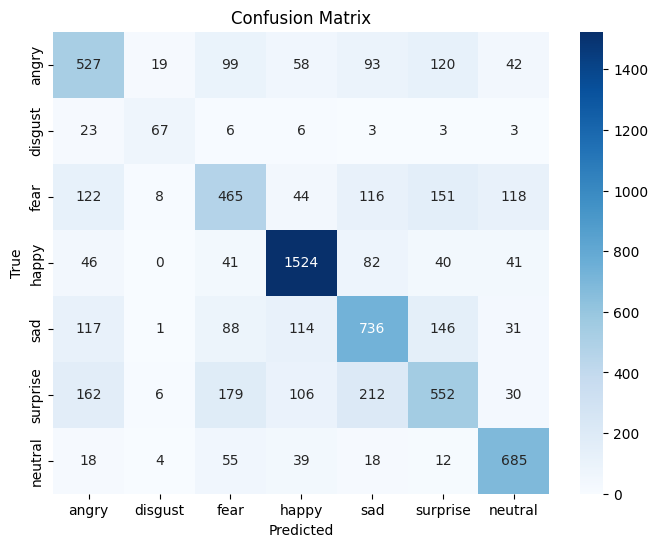

In [14]:
# Confusion Matrix
cm = confusion_matrix(val_set.classes, val_preds_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_list, yticklabels=emotion_list)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

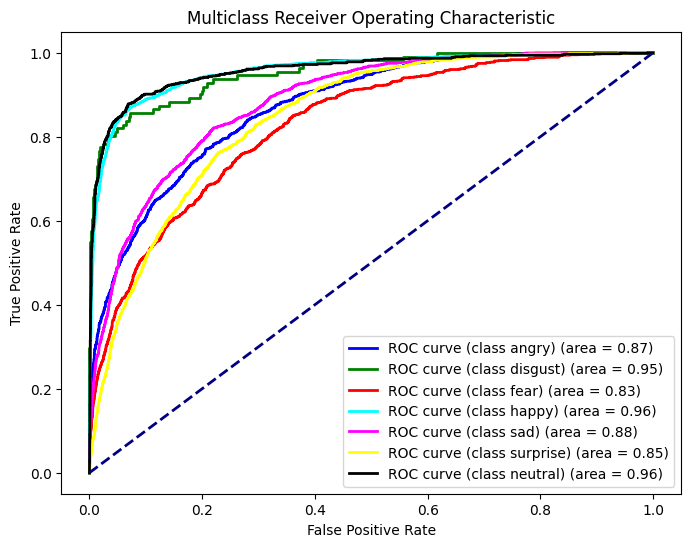

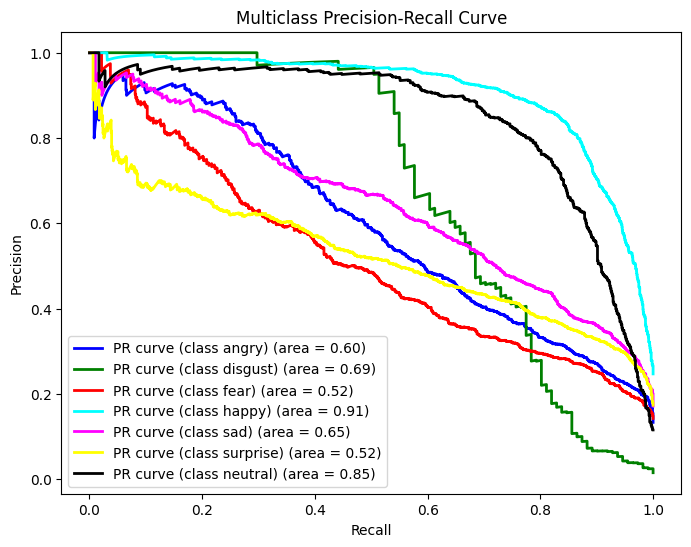

In [16]:
from sklearn.preprocessing import label_binarize

# Convert the true labels to one-hot encoded format
y_true = label_binarize(val_set.classes, classes=np.arange(7))  # Assuming 7 classes

# Compute ROC for each class
n_classes = y_true.shape[1]
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], val_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (class {emotion_list[i]}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for each class
precision, recall, pr_auc = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], val_preds[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot Precision-Recall curves for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2, label=f'PR curve (class {emotion_list[i]}) (area = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [17]:
# Results Table
results = pd.DataFrame({
    "Accuracy": [history.history['accuracy'][-1]],
    "Precision": [precision],
    "Recall": [recall],
    "F1 Score": [f1]
})

In [18]:
# Results Table
results = pd.DataFrame({
    "Accuracy": [history.history['accuracy'][-1]],
    "Precision": [precision],
    "Recall": [recall],
    "F1 Score": [f1]
})

print(results)


   Accuracy                                          Precision  \
0  0.921875  {0: [0.13346336026748398, 0.13348195624912917,...   

                                              Recall  F1 Score  
0  {0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...  0.629154  


Explanation for Class: angry


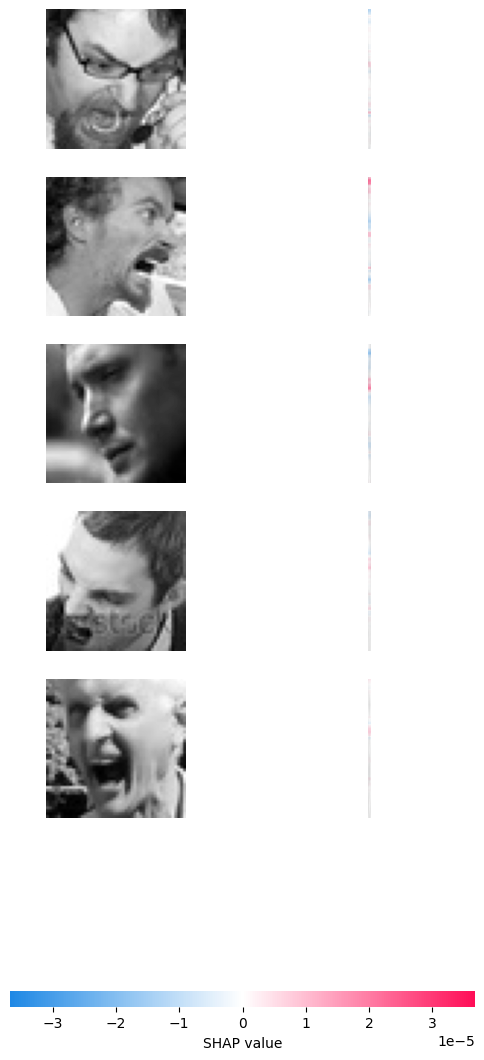

Explanation for Class: disgust


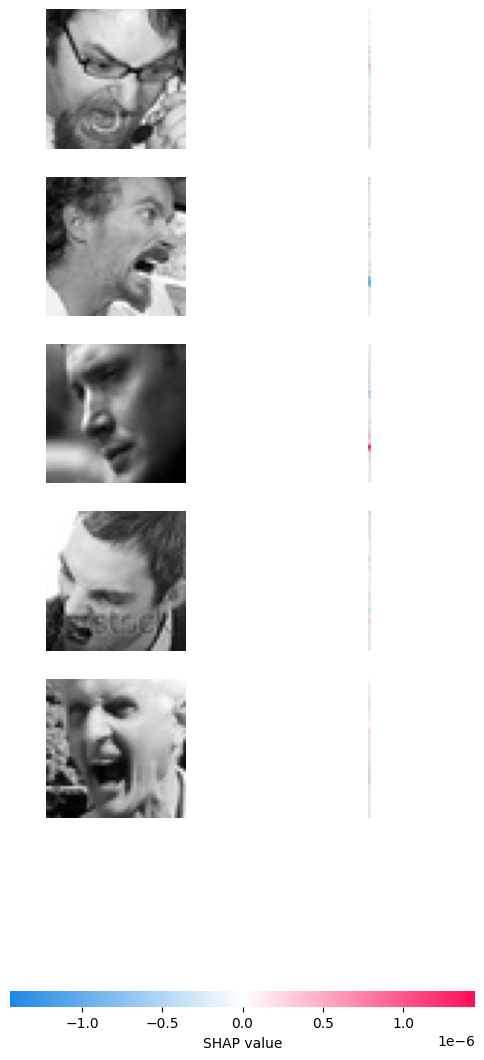

Explanation for Class: fear


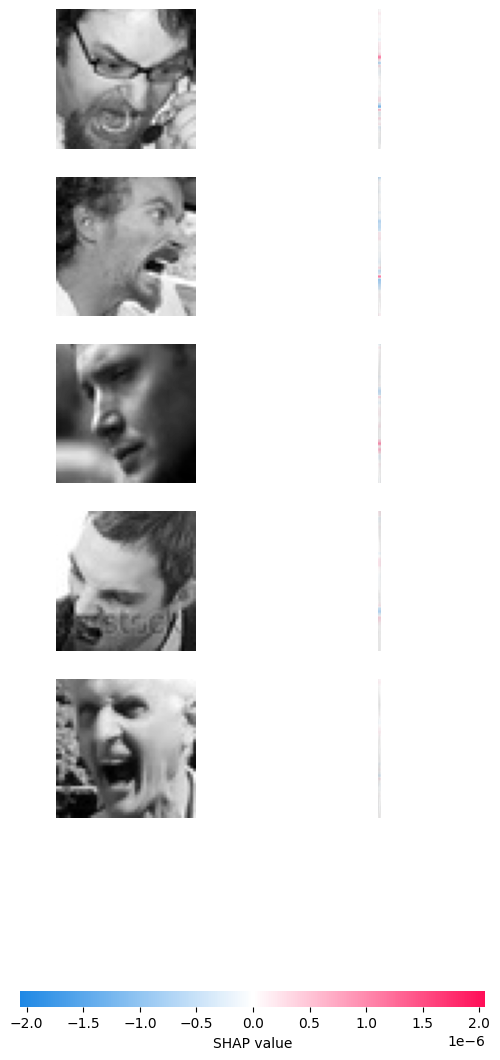

Explanation for Class: happy


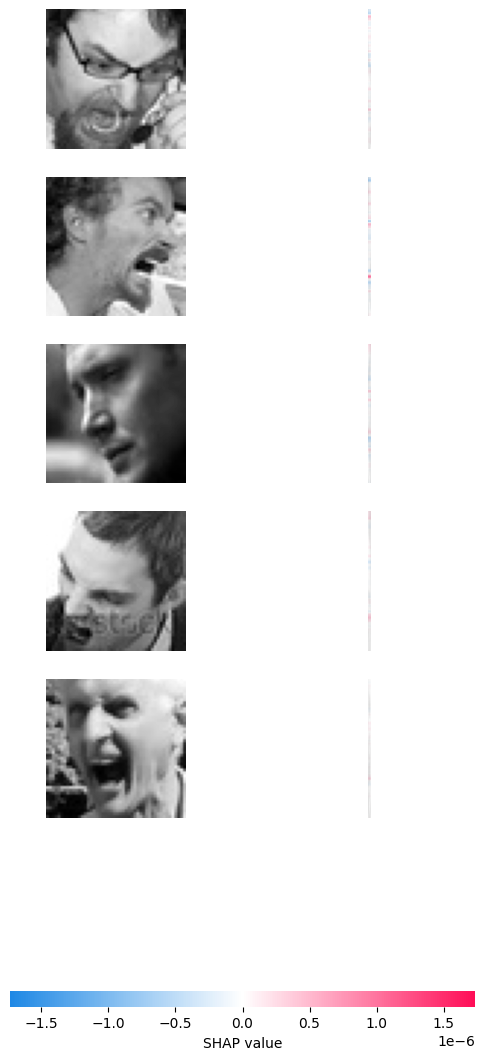

Explanation for Class: sad


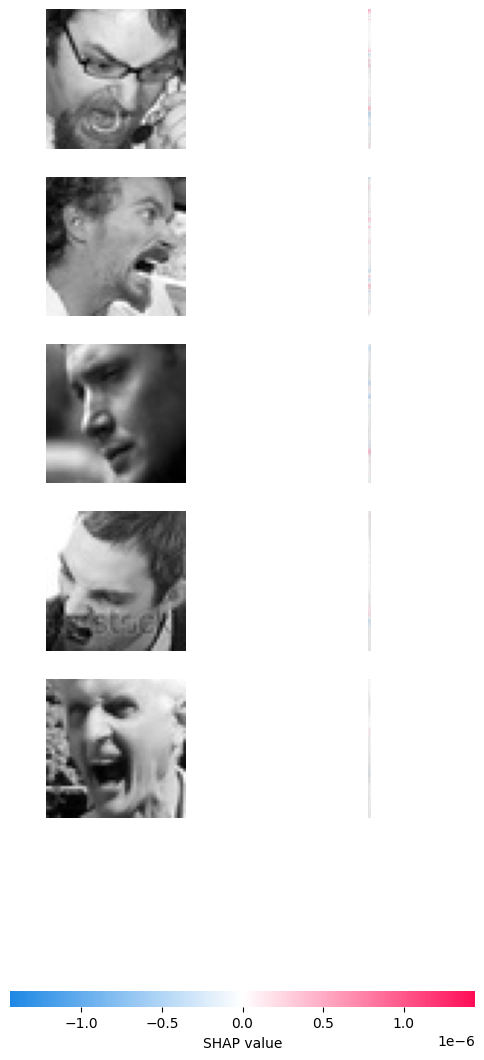

In [32]:
import shap  # Import SHAP library

# Initialize SHAP explainer
# We will use DeepExplainer for this model
explainer = shap.DeepExplainer(model, train_set[0][0])  # Using the first batch of training data as background

# Select a batch of images from the validation set for explanation
val_images, val_labels = val_set[0]  # Get the first batch of validation images and labels

# Explain predictions for the first few images
shap_values = explainer.shap_values(val_images[:5])  # Explaining the first 5 images

# Visualize the SHAP values for each emotion class
for i in range(len(shap_values)):
    print(f"Explanation for Class: {emotion_list[i]}")
    shap.image_plot([shap_values[i]], val_images[:5])


Explanation for Class: happy


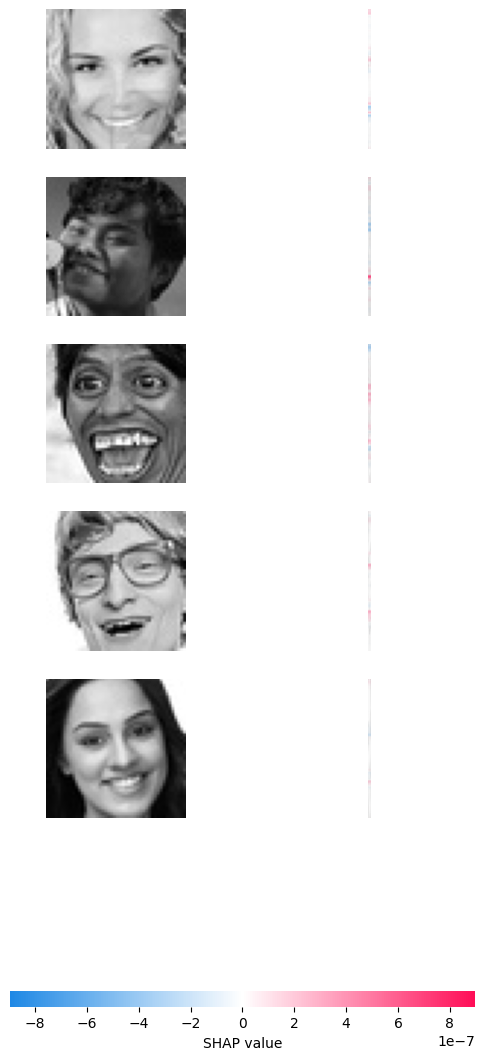

In [38]:
# Initialize SHAP explainer
# Use DeepExplainer for this model
explainer = shap.DeepExplainer(model, train_set[0][0])  # Using the first batch of training data as background

# Find a batch with "happy" faces
found_happy_images = False
for batch_images, batch_labels in val_set:
    happy_indices = np.where(np.argmax(batch_labels, axis=1) == emotion_list.index('happy'))[0]
    if len(happy_indices) > 0:  # Check if there are "happy" images in this batch
        happy_images = batch_images[happy_indices][:5]  # Select the first 5 "happy" images
        found_happy_images = True
        break

if not found_happy_images:
    print("No 'happy' images found in the validation set.")
else:
    # Explain predictions for the selected "happy" faces
    shap_values = explainer.shap_values(happy_images)  # Generate SHAP values for "happy" images

    # Visualize the SHAP values for the "happy" class
    happy_class_index = emotion_list.index('happy')  # Index for the "happy" class
    print(f"Explanation for Class: {emotion_list[happy_class_index]}")
    shap.image_plot([shap_values[happy_class_index]], happy_images)


Explanation for Class: sad


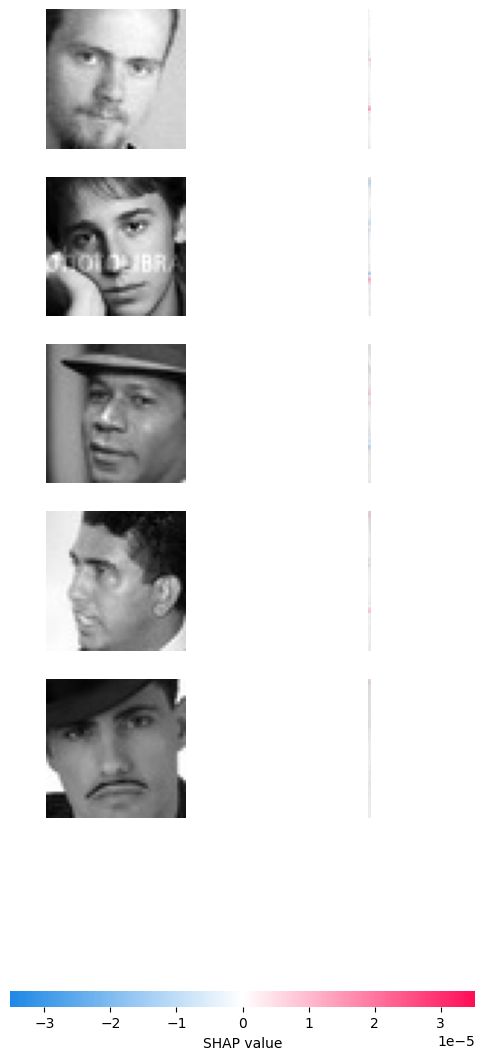

In [40]:
# Initialize SHAP explainer
# Use DeepExplainer for this model
explainer = shap.DeepExplainer(model, train_set[0][0])  # Using the first batch of training data as background

# Find a batch with "sad" faces
found_sad_images = False
for batch_images, batch_labels in val_set:
    sad_indices = np.where(np.argmax(batch_labels, axis=1) == emotion_list.index('sad'))[0]
    if len(sad_indices) > 0:  # Check if there are "sad" images in this batch
        sad_images = batch_images[sad_indices][:5]  # Select the first 5 "sad" images
        found_sad_images = True
        break

if not found_sad_images:
    print("No 'sad' images found in the validation set.")
else:
    # Explain predictions for the selected "sad" faces
    shap_values = explainer.shap_values(sad_images)  # Generate SHAP values for "sad" images

    # Visualize the SHAP values for the "sad" class
    sad_class_index = emotion_list.index('sad')  # Index for the "sad" class
    print(f"Explanation for Class: {emotion_list[sad_class_index]}")
    shap.image_plot([shap_values[sad_class_index]], sad_images)


In [41]:
# Save the entire model (architecture + weights)
model.save('emotion_recognition_model.h5')

